This script is for calculating the Dispersive surface energy ($\gamma_{d}^{s}$) of a solid sample from Inverse Gas Chromatography measurements, specifically those done on the SEA (Surface energy analyser).  Measured parameters are imported from a csv file and the dispersive surface energy profile (including error and $R^{2}$ value of the fit) is shown and results are output to a different csv file.

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats,constants
from __future__ import division

# Input data is sorted to be usable

In [2]:
# reads the experimental data file. note: remove other exp details
# Change nrows and skiprows depending on amount of injections
# skiprows skips the first x rows of csv while nrows reads the first x - 1 rows 
f = pd.read_csv(raw_input('Copy path to input file here \nmake sure to insert extra "\\" and remove "" \n'),skiprows=8,nrows=105,
                encoding='utf-16', delimiter='\t')

Copy path to input file here 
make sure to insert extra "\" and remove "" 
C:\\Users\\tcd\\Google Drive\\Graphene size study feb 2015\\IGC_raw_data\\Surface_energy\\300-500rpm\\run1\\300-500rpm_90C_run1.csv


In [3]:
# Removes  columns that have all null values
df = f.dropna(axis =1, how='all')

In [4]:
# Get rid of columns unrelated to dispersive solvents
df.drop(df.columns[2:7],axis=1,inplace=True)

In [5]:
# Renames columns to make life easier
df.rename(columns = {'n/nm' : 'n_nm',
                     'Solvent Name' : 'solvent',
                     'Interpolated Retention Volume (Max)' : 'max',
                     'Interpolated Retention Volume (Com)' : 'com',
                     'Column Temperature [Kelvin]': 'temperature (K)'},inplace=True)

In [6]:
# Gets rid of Specifc solvents
# NOTE: IF MORE OR LESS OR DIFFERENT SOLVENTS USED CHANGE THIS LINE ACCORDINGLY
df = df[(df.solvent != 'DICHLOROMETHANE') & (df.solvent != 'ETHYL ACETATE') & (df.solvent != '1,4-DIOXANE')]

In [7]:
# Dictionary for map used in next line
solvent_map = {'NONANE': 9,
               'OCTANE' : 8,
               'HEPTANE' : 7,
               'HEXANE' : 6}

In [8]:
# New columns that maps the carbon number from solvent column. Carbon number is needed for calculations
df['carbon num'] = df['solvent'].map(solvent_map)

# Calculations

Gibbs Free Energy of adsorption is calculated by $\Delta G=RT\ln V_{n}$ ($\frac{kJol}{Mol})$ where $V_{n}$ is the column called 'com'

In [9]:
# Import real gas const
# RTLnVn is the Gibbs free energy of adsorption
R= constants.R
df['RTLnVn'] = R * df['temperature (K)'] * np.log(df['com'])

In [10]:
# Creates coverage list for the data set
cov = df['n_nm'].unique().tolist()

In [11]:
# List where each element corresponds to part of dataframe with coverage value
cov_sep_list = [df.loc[df.n_nm == i] for i in cov]

In [12]:
# Linear Regression on Gibbs free energy of adsorption vs carbon number
# result is list of tuples containing slope, standard error of slope, r_value etc in a list of tuples
result = [stats.linregress(df['carbon num'],df['RTLnVn']) for df in cov_sep_list]

In [13]:
# Unzips list of tuples to individual tuples
slopes, intercepts,r_values,p_values,std_errs = zip(*result)

In [14]:
# turns tuples to numpy arrays for calculations
slopes = np.array(slopes)

In [15]:
r_values = np.array(r_values)
std_errs = np.array(std_errs)

In [16]:
# Computes R^2 of linear fit
r_sq_arr = r_values ** 2

In [17]:
# values used in surface energy equation (Dorris-Gray)
# T = experiment temperature, y_ch2 = dispersive surface energy of methylene group
# a_ch2 = cross sectional surface area of methylene group

T = f['Column Temperature [Kelvin]'].mean()
y_ch2 = 35.6 + 0.058 * (293 - T)
y_ch2 = y_ch2 / 1000
Na = constants.Avogadro
a_ch2 = 6E-20

Dorris-Gray equation for the calculation of the dispersive surface energy ($\gamma_{d}^{s}$) of a solvent, $unit=\frac{mJ}{m^{2}}$

$$\gamma_{d}^{s}=\frac{1}{4\gamma_{d}^{CH2}}\left(\frac{RT.ln\left[\frac{V_{N,n+1}}{V_{N,n}}\right]}{N_{a}a_{CH2}}\right)^{2}$$

$$\gamma_{d}^{s}=\frac{1}{4\gamma_{d}^{CH2}}\left(\frac{slope}{N_{a}a_{CH2}}\right)^{2}$$

In [18]:
# Dorris-Gray equation for dispersive surface energy
y_d = (1/(4 * y_ch2)) * (slopes/(Na * a_ch2)) ** 2

In [19]:
# Converts from J/m^2 to mJ/m^2
y_d = y_d * 1000

In [20]:
# Calculates error in y_d from standard error in slope of fitting
y_d_err = (y_d * 2 * std_errs) / slopes

# Output and plotting of $\gamma_{d}^{s}$ profile

In [21]:
# Creates dataframe of results with coverage used as index
results_df = DataFrame({'Coverage' : cov,
                       'Dispersive Surface Energy (COM)' : y_d,
                       'Error': y_d_err,
                       'R Square' : r_sq_arr},)
results_df.set_index(keys = 'Coverage',inplace=True)
results_df

,Dispersive Surface Energy (COM),Error,R Square
Coverage,,,
0.0075,126.311738,8.264816,0.997864
0.0100,126.088622,9.516388,0.997160
0.0200,124.566308,8.970145,0.997414
0.0300,120.700007,7.139293,0.998254
0.0500,113.800363,3.631444,0.999491
0.0700,110.288704,1.132076,0.999947
0.0900,104.892302,2.130619,0.999794
0.1000,104.427592,3.002952,0.999587
0.1300,99.091487,4.132004,0.999131


In [22]:
# Exports results to a csv name of your choosing
results_df.to_csv(raw_input('copy output directory you want and put .csv after \n'))

copy output directory you want and put .csv after 
C:\\Users\\tcd\\Google Drive\\Graphene size study feb 2015\\IGC_raw_data\\Surface_energy\\300-500rpm\\run1\\results.csv


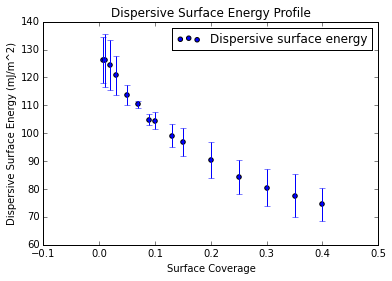

In [24]:
# Plots dispersive surface energy profile with error bars
plt.scatter(cov,y_d,label= 'Dispersive surface energy')
plt.errorbar(cov, y_d,yerr=y_d_err,linestyle = 'None')
plt.title('Dispersive Surface Energy Profile')
plt.xlabel('Surface Coverage')
plt.ylabel('Dispersive Surface Energy (mJ/m^2)')
plt.legend(loc='upper right')